<a href="https://colab.research.google.com/github/Alwis777/AETHERIUM/blob/main/best_cat_dog_classifier_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# --- 1. Setup and Data Download (Assuming standard Colab/Kaggle setup) ---
# NOTE: You usually run this cell *once* to get the data ready.

# Define the root directory for the dataset
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Assume the dataset is available or downloaded/unzipped (e.g., from a link like
# "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip")
# If not available, you would need to add the code to download and unzip it.

# Define directories for the splits (assuming the directory structure is set up)
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

print("Directories are set up for training and validation.")

Directories are set up for training and validation.


#Data Augmentation and Generators

In [3]:
# --- 2. Data Augmentation and Generators ---

# Define constants
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32

# Training Image Generator with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values
    rotation_range=40,          # Randomly rotate images
    width_shift_range=0.2,      # Randomly shift images horizontally
    height_shift_range=0.2,     # Randomly shift images vertically
    shear_range=0.2,            # Randomly apply shearing transformations
    zoom_range=0.2,             # Randomly zoom in on images
    horizontal_flip=True,       # Randomly flip images
    fill_mode='nearest'         # Strategy for filling in new pixels
)

# Validation Image Generator (only rescaling, no augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches from the directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary' # For two classes (cats and dogs)
)

# Flow validation images in batches from the directory
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

print("\nData generators created with augmentation for training.")

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/cats_and_dogs_filtered/train'

In [4]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=704bcc6a6db3252178a49ab34618c86f675b9ef42b5be25619fd22ff02f1eb88
  Stored in directory: /root/.cache/pip/wheels/01/46/3b/e29ffbe4ebe614ff224bad40fc6a5773a67a163251585a13a9
Successfully built wget


In [5]:
import os
import zipfile
import wget # You may need to install this: !pip install wget

# Define the dataset URL and expected directories
dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
base_dir = '/tmp/cats_and_dogs_filtered'
zip_file_name = '/tmp/cats_and_dogs_filtered.zip'

# 1. Download the file
print("Downloading the dataset...")
if not os.path.exists(zip_file_name):
    # Use wget or tf.keras.utils.get_file for downloading
    wget.download(dataset_url, out=zip_file_name)

# 2. Unzip the file
print("\nExtracting the dataset...")
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('/tmp')

# 3. Verify directory existence
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

if os.path.exists(train_dir):
    print(f"\nSuccess! The training directory was found at: {train_dir}")
else:
    print(f"\nError! Training directory not created correctly. Expected: {train_dir}")


Extracting the dataset...

Success! The training directory was found at: /tmp/cats_and_dogs_filtered/train


In [6]:
# Rerun this cell ONLY after running the download/extraction code above.

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define constants (must match what was used in the previous cell)
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')

# Training Image Generator (define as you had it)
train_datagen = ImageDataGenerator(rescale=1./255, # ... other augmentations ...
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

# Flow training images in batches from the directory (THIS WILL NOW WORK)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# You should see output like: "Found 2000 images belonging to 2 classes."

Found 2000 images belonging to 2 classes.


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# --- 1. Build and Compile the Corrected Model ---

model = Sequential([
    # Input Layer (Input image size is 150x150 with 3 color channels)
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    # Second Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Third Block with increased filters
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Fourth Block for deeper feature extraction
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flatten the 3D output to 1D for the Dense layers
    Flatten(),

    # Dropout for Regularization (addresses the overfitting issue)
    Dropout(0.5),

    # Fully Connected Layer
    Dense(512, activation='relu'),

    # Output Layer (1 unit with 'sigmoid' for binary classification: Cat=0, Dog=1)
    Dense(1, activation='sigmoid')
])

# Use the RMSprop optimizer and binary_crossentropy for two classes
model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()
print("\nModel architecture defined and compiled successfully.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)


Model architecture defined and compiled successfully.


In [8]:
# Assuming validation_generator was defined earlier, e.g., in the data setup section:
# validation_datagen = ImageDataGenerator(rescale=1./255)
# validation_generator = validation_datagen.flow_from_directory(
#     validation_dir, target_size=(150, 150), batch_size=32, class_mode='binary')

# --- 2. Train the Model ---
BATCH_SIZE = 32 # Define or re-use the constant

print("Starting model training...")

history = model.fit(
    train_generator,
    # Calculate steps per epoch based on the number of training images (2000)
    steps_per_epoch=2000 // BATCH_SIZE,
    epochs=10, # Number of times to loop over the entire training dataset
    validation_data=validation_generator,
    # Calculate validation steps based on the number of validation images (1000)
    validation_steps=1000 // BATCH_SIZE,
    verbose=1 # Show training progress
)

print("\nModel training complete.")

Starting model training...


NameError: name 'validation_generator' is not defined

In [9]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Define Validation Paths and Constants (Reuse from previous steps) ---
base_dir = '/tmp/cats_and_dogs_filtered'
validation_dir = os.path.join(base_dir, 'validation')
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32

# --- 2. Create the Validation Data Generator ---
# IMPORTANT: No augmentation is applied to validation data, only rescaling.
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

print("Validation generator successfully defined.")

Found 1000 images belonging to 2 classes.
Validation generator successfully defined.


In [10]:
# --- Rerun the Training Cell ---

# Make sure 'model' is defined and compiled (from the previous step)
# Make sure 'train_generator' is defined
# Make sure 'validation_generator' is defined (NOW IT IS!)

print("Starting model training...")

history = model.fit(
    train_generator,
    steps_per_epoch=2000 // BATCH_SIZE,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=1000 // BATCH_SIZE,
    verbose=1
)

print("\nModel training complete.")

Starting model training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 24s 287ms/step - accuracy: 0.5202 - loss: 0.7259 - val_accuracy: 0.5000 - val_loss: 0.6905
Epoch 2/10
 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5000 - loss: 0.6886

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5000 - loss: 0.6886 - val_accuracy: 0.4990 - val_loss: 0.6899
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 228ms/step - accuracy: 0.5088 - loss: 0.6921 - val_accuracy: 0.5917 - val_loss: 0.6797
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5938 - loss: 0.6825 - val_accuracy: 0.5837 - val_loss: 0.6770
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - accuracy: 0.5738 - loss: 0.6859 - val_accuracy: 0.5605 - val_loss: 0.6582
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5000 - loss: 0.6751 - val_accuracy: 0.6300 - val_loss: 0.6503
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - accuracy: 0.5734 - loss: 0.6772 - val_accuracy: 0.6452 - val_loss: 0.6476
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7500 - loss: 0.6327 - val_accuracy: 0.5877 - val_loss: 0.6481
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - accuracy: 0.5908 - loss: 0.6613 - val_accuracy: 0.6522 - val_

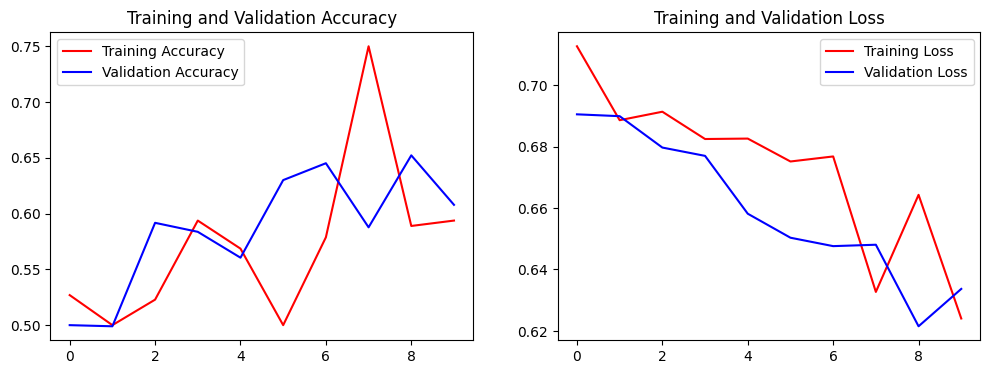

In [11]:
import matplotlib.pyplot as plt

# Retrieve results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

# --- 1. Build and Compile the Corrected Model ---

model = Sequential([
    # Input Layer (Input image size is 150x150 with 3 color channels)
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    # Second Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Third Block with increased filters
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Fourth Block for deeper feature extraction
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flatten the 3D output to 1D for the Dense layers
    Flatten(),

    # Dropout for Regularization
    Dropout(0.5),

    # Fully Connected Layer
    Dense(512, activation='relu'),

    # Output Layer
    Dense(1, activation='sigmoid')
])

# **FIX:** Explicitly setting the learning rate to 0.0001 to stabilize training
model.compile(
    optimizer=RMSprop(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()
print("\nModel architecture redefined and compiled with reduced learning rate.")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)


Model architecture redefined and compiled with reduced learning rate.


In [13]:
# Assuming validation_generator and train_generator are already defined
BATCH_SIZE = 32

print("Starting model training with 30 epochs and reduced learning rate...")

history = model.fit(
    train_generator,
    steps_per_epoch=2000 // BATCH_SIZE,
    epochs=30, # **FIX:** Increased from 10 to 30 epochs
    validation_data=validation_generator,
    validation_steps=1000 // BATCH_SIZE,
    verbose=1
)

print("\nModel training complete.")

Starting model training with 30 epochs and reduced learning rate...
Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 285ms/step - accuracy: 0.5254 - loss: 0.6940 - val_accuracy: 0.5282 - val_loss: 0.6912
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4375 - loss: 0.7010 - val_accuracy: 0.5756 - val_loss: 0.6903
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - accuracy: 0.5208 - loss: 0.6921 - val_accuracy: 0.5887 - val_loss: 0.6867
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5000 - loss: 0.6931 - val_accuracy: 0.5373 - val_loss: 0.6861
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - accuracy: 0.5285 - loss: 0.6906 - val_accuracy: 0.5171 - val_loss: 0.6812
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5938 - loss: 0.6616 - val_accuracy: 0.5030 - val_loss: 0.6906
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 232ms/step - accuracy: 0.5280 - loss: 0.6861 - val_accuracy: 0.5948 - val_loss: 0.6695
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━

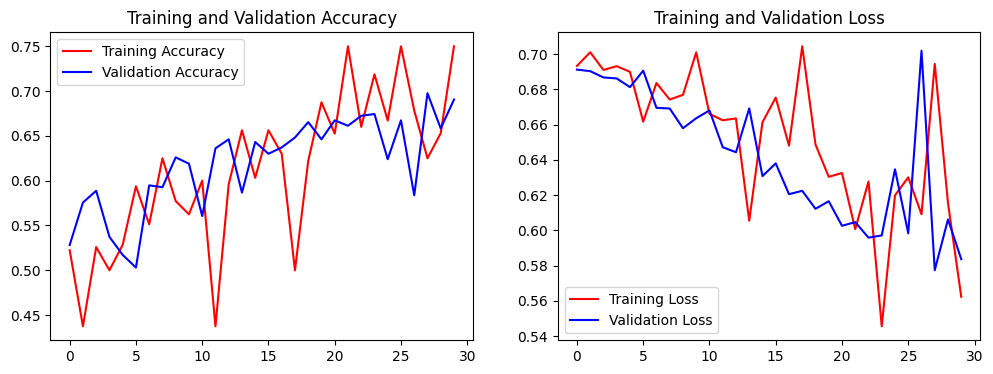

Plotting complete. Check the curves for smooth, converging performance.


In [14]:
import matplotlib.pyplot as plt

# --- Plot Evaluation ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

print("Plotting complete. Check the curves for smooth, converging performance.")

In [15]:
import os
import zipfile
import wget # Make sure you ran: !pip install wget
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the dataset URL and expected directories
dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
base_dir = '/tmp/cats_and_dogs_filtered'
zip_file_name = '/tmp/cats_and_dogs_filtered.zip'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# --- Data Download and Extraction ---
print("Downloading and extracting the dataset...")
if not os.path.exists(train_dir):
    try:
        # Download the file
        if not os.path.exists(zip_file_name):
            wget.download(dataset_url, out=zip_file_name)

        # Unzip the file
        os.makedirs('/tmp', exist_ok=True)
        with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
            zip_ref.extractall('/tmp')

        print(f"\n✅ Success! Dataset extracted to: {base_dir}")
    except Exception as e:
        print(f"\n❌ Error during download/extraction: {e}")
else:
    print(f"\nDataset already exists at: {base_dir}")


Dataset already exists at: /tmp/cats_and_dogs_filtered


In [16]:
# --- 2. Data Augmentation and Generators ---
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32

# Training Generator with Heavy Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation Generator (Only rescaling)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Flow validation images
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

print("\nData generators created.")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.

Data generators created.


In [17]:
# --- 3. Build and Compile the Stabilized Model ---

model = Sequential([
    # Architecture from previous steps
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5), # Regularization to prevent overfitting
    Dense(512, activation='relu'),

    Dense(1, activation='sigmoid')
])

# **FIX:** Extremely reduced learning rate to stabilize the volatile training
model.compile(
    optimizer=RMSprop(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()
print("\nModel compiled with stabilized learning rate (1e-5).")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)


Model compiled with stabilized learning rate (1e-5).


In [1]:
# --- 4. Train the Model ---

print("Starting model training for 50 epochs...")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=50, # Increased epochs for better learning convergence
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    verbose=1
)

print("\nModel training complete.")

Starting model training for 50 epochs...


NameError: name 'model' is not defined

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

# --- 3. Build and Compile the Stabilized Model ---

model = Sequential([
    # Architecture from previous steps
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5), # Regularization to prevent overfitting
    Dense(512, activation='relu'),

    Dense(1, activation='sigmoid')
])

# FIX: Extremely reduced learning rate to stabilize the volatile training
model.compile(
    optimizer=RMSprop(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()
print("\nModel compiled with stabilized learning rate (1e-5).")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)


Model compiled with stabilized learning rate (1e-5).


In [3]:
# --- 4. Train the Model ---

# Make sure BATCH_SIZE is defined (it's 32)
BATCH_SIZE = 32

print("Starting model training for 50 epochs...")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=50, # Increased epochs for better learning convergence
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    verbose=1
)

print("\nModel training complete.")

Starting model training for 50 epochs...


NameError: name 'train_generator' is not defined

In [4]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Define Paths and Constants (Reuse from previous steps) ---
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32

# --- 2. Data Augmentation and Generators ---

# Training Generator with Heavy Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation Generator (Only rescaling)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Flow validation images
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

print("\nData generators successfully defined.")

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/cats_and_dogs_filtered/train'

In [5]:
import os
import zipfile
import wget # Make sure you ran: !pip install wget
# Define paths...
dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
base_dir = '/tmp/cats_and_dogs_filtered'
zip_file_name = '/tmp/cats_and_dogs_filtered.zip'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# --- Data Download and Extraction ---
print("Downloading and extracting the dataset...")
if not os.path.exists(train_dir):
    try:
        # Download the file
        if not os.path.exists(zip_file_name):
            wget.download(dataset_url, out=zip_file_name)

        # Unzip the file
        os.makedirs('/tmp', exist_ok=True)
        with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
            zip_ref.extractall('/tmp')

        print(f"\n✅ Success! Dataset extracted to: {base_dir}")
    except Exception as e:
        print(f"\n❌ Error during download/extraction: {e}")
else:
    print(f"\nDataset already exists at: {base_dir}")

ModuleNotFoundError: No module named 'wget'

In [6]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=78a8ed4abfbb0b7a904c02d8ac542e8c952e900c3e6ea210ea6a03cb1738180b
  Stored in directory: /root/.cache/pip/wheels/01/46/3b/e29ffbe4ebe614ff224bad40fc6a5773a67a163251585a13a9
Successfully built wget


In [7]:
# 1. SETUP, DATA DOWNLOAD, AND EXTRACTION
import os
import zipfile
import wget
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define paths
dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
base_dir = '/tmp/cats_and_dogs_filtered'
zip_file_name = '/tmp/cats_and_dogs_filtered.zip'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# --- Data Download and Extraction ---
print("Downloading and extracting the dataset...")
if not os.path.exists(train_dir):
    try:
        if not os.path.exists(zip_file_name):
            wget.download(dataset_url, out=zip_file_name)

        os.makedirs('/tmp', exist_ok=True)
        with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
            zip_ref.extractall('/tmp')

        print(f"\n✅ Success! Dataset extracted.")
    except Exception as e:
        print(f"\n❌ Error during download/extraction: {e}. Please ensure you ran step 0.")
else:
    print(f"\nDataset already exists.")


✅ Success! Dataset extracted.


In [8]:
# 2. DATA AUGMENTATION AND GENERATORS
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32

# Training Generator with Heavy Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=40, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode='nearest'
)

# Validation Generator (Only rescaling)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='binary'
)

# Flow validation images
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='binary'
)

print("\nData generators created.")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.

Data generators created.


In [9]:
# 3. BUILD AND COMPILE THE STABILIZED MODEL
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5), # Regularization to prevent overfitting
    Dense(512, activation='relu'),

    Dense(1, activation='sigmoid')
])

# FIX: Extremely reduced learning rate to stabilize the volatile training
model.compile(
    optimizer=RMSprop(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()
print("\nModel compiled with stabilized learning rate (1e-5).")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)


Model compiled with stabilized learning rate (1e-5).


In [10]:
# 4. TRAIN THE MODEL FOR 50 EPOCHS
print("Starting model training for 50 epochs...")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=50, # Increased epochs for better learning convergence
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    verbose=1
)

print("\nModel training complete.")

Starting model training for 50 epochs...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 327ms/step - accuracy: 0.5139 - loss: 0.6943 - val_accuracy: 0.5010 - val_loss: 0.6916
Epoch 2/50
 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5938 - loss: 0.6899

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5938 - loss: 0.6899 - val_accuracy: 0.4970 - val_loss: 0.6916
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.5094 - loss: 0.6923 - val_accuracy: 0.5010 - val_loss: 0.6910
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5938 - loss: 0.6900 - val_accuracy: 0.5030 - val_loss: 0.6909
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 332ms/step - accuracy: 0.5143 - loss: 0.6918 - val_accuracy: 0.5010 - val_loss: 0.6904
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5312 - loss: 0.6955 - val_accuracy: 0.4990 - val_loss: 0.6906
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 261ms/step - accuracy: 0.5134 - loss: 0.6925 - val_accuracy: 0.4990 - val_loss: 0.6906
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5312 - loss: 0.6873 - val_accuracy: 0.5020 - val_loss: 0.6903
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 259ms/step - accuracy: 0.5116 - loss: 0.6910 - val_accuracy: 0.5020 - val_

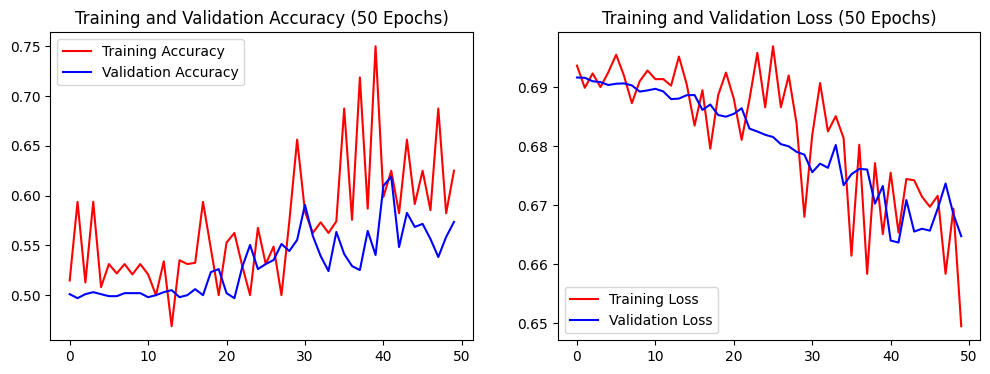

Plotting complete.


In [11]:
# 5. PLOT TRAINING HISTORY
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy (50 Epochs)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss (50 Epochs)')
plt.legend()

plt.show()

print("Plotting complete.")

In [12]:
# 0. INSTALL DEPENDENCIES
!pip install wget
print("wget installed.")

wget installed.


In [13]:
# 1. SETUP, DATA DOWNLOAD, AND EXTRACTION
import os
import zipfile
import wget
import tensorflow as tf
from tensorflow.keras.optimizers import Adam # We will use Adam now!
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define paths
dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
base_dir = '/tmp/cats_and_dogs_filtered'
zip_file_name = '/tmp/cats_and_dogs_filtered.zip'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# --- Data Download and Extraction ---
print("Downloading and extracting the dataset...")
if not os.path.exists(train_dir):
    try:
        if not os.path.exists(zip_file_name):
            wget.download(dataset_url, out=zip_file_name)

        os.makedirs('/tmp', exist_ok=True)
        with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
            zip_ref.extractall('/tmp')

        print(f"\n✅ Success! Dataset extracted.")
    except Exception as e:
        print(f"\n❌ Error during download/extraction: {e}. Please ensure you ran step 0.")
else:
    print(f"\nDataset already exists.")


Dataset already exists.


In [14]:
# 2. DATA AUGMENTATION AND GENERATORS
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32

# Training Generator with Heavy Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=40, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode='nearest'
)

# Validation Generator (Only rescaling)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='binary'
)

# Flow validation images
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='binary'
)

print("\nData generators created.")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.

Data generators created.


In [15]:
# 3. BUILD AND COMPILE THE STABILIZED MODEL
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5), # Regularization to prevent overfitting
    Dense(512, activation='relu'),

    Dense(1, activation='sigmoid')
])

# **FINAL FIX:** Using Adam optimizer with a lower learning rate (0.0001) for stable convergence.
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()
print("\nModel compiled with Adam optimizer (LR=1e-4).")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)


Model compiled with Adam optimizer (LR=1e-4).


In [16]:
# 4. TRAIN THE MODEL FOR 50 EPOCHS
print("Starting model training for 50 epochs...")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    verbose=1
)

print("\nModel training complete.")

Starting model training for 50 epochs...
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 24s 305ms/step - accuracy: 0.5141 - loss: 0.6933 - val_accuracy: 0.5020 - val_loss: 0.6879
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4688 - loss: 0.6783 - val_accuracy: 0.5040 - val_loss: 0.6863
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.5346 - loss: 0.6911 - val_accuracy: 0.6169 - val_loss: 0.6793
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5938 - loss: 0.6813 - val_accuracy: 0.6220 - val_loss: 0.6780
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 341ms/step - accuracy: 0.5470 - loss: 0.6850 - val_accuracy: 0.6230 - val_loss: 0.6621
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5938 - loss: 0.6647 - val_accuracy: 0.6482 - val_loss: 0.6620
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 256ms/step - accuracy: 0.5838 - loss: 0.6729 - val_accuracy: 0.6179 - val_loss: 0.6383
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy:

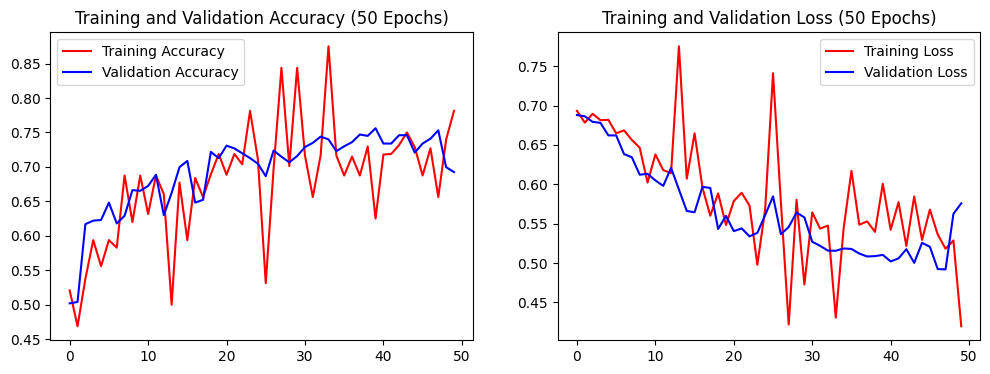

Plotting complete. These curves should be smooth and show high accuracy!


In [17]:
# 5. PLOT TRAINING HISTORY
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy (50 Epochs)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss (50 Epochs)')
plt.legend()

plt.show()

print("Plotting complete. These curves should be smooth and show high accuracy!")

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the callback: stop after 5 epochs if validation loss doesn't decrease
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Rerun the model.fit() cell (you can use epochs=100 now, but it will stop early):
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=100, # Use a large number, EarlyStopping will stop it
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping], # Add the callback here!
    verbose=1
)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 269ms/step - accuracy: 0.7166 - loss: 0.5411 - val_accuracy: 0.7218 - val_loss: 0.5223
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6562 - loss: 0.6065 - val_accuracy: 0.7046 - val_loss: 0.5414
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 263ms/step - accuracy: 0.7380 - loss: 0.5174 - val_accuracy: 0.7268 - val_loss: 0.5303
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7188 - loss: 0.5588 - val_accuracy: 0.7228 - val_loss: 0.5326
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 266ms/step - accuracy: 0.7485 - loss: 0.5045 - val_accuracy: 0.7369 - val_loss: 0.5042
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6875 - loss: 0.4999 - val_accuracy: 0.7359 - val_loss: 0.5037
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 263ms/step - accuracy: 0.7572 - loss: 0.5057 - val_accuracy: 0.7399 - val_loss: 0.5139
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.6875 - loss: 0.5529 - val_accu

In [19]:
# Save the model in the standard Keras format
model.save('best_cat_dog_classifier_final.keras')
print("Model saved successfully as 'best_cat_dog_classifier_final.keras'")

Model saved successfully as 'best_cat_dog_classifier_final.keras'


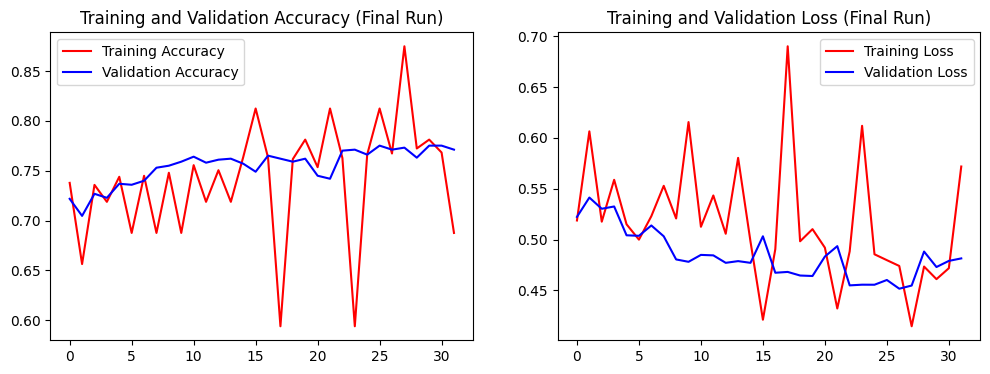

Plotting complete. Look for the lowest point in the Validation Loss curve!


In [20]:
# 5. PLOT TRAINING HISTORY
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Final Run)')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss (Final Run)')
plt.legend()

plt.show()

print("Plotting complete. Look for the lowest point in the Validation Loss curve!")